In [34]:
import logging
import shutil
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio
import tqdm
from matplotlib import pyplot as plt
from rasterio.plot import show
from rasterio.warp import (
    Resampling,
    calculate_default_transform,
    reproject,
    transform_geom,
)
from shapely.geometry import box, Polygon
import satellite_images_nso.__lidar.ahn as ahn
from satellite_images_nso._index_channels.calculate_index_channels import (
    generate_ndvi_channel,
    generate_ndwi_channel,
    generate_red_edge_ndvi_channel,
)
from shapely.geometry import mapping

In [35]:
def __getFeatures( path):
        """
        Function to parse features from GeoDataFrame in such a manner that the NSO api wants them.

        @param path: The path to a geojson.
        @return polygon_to_crop: The first returned variable is a polygon to which the satellite image has to be cropped.
        @return polygon_to_down: The second returned variable returns a buffed polygon to download with.
        @return buffered_polygon: A boolean which checks if a polygon has been buffered.
        """
        gdf = gpd.read_file(path)
        json_loaded = json.loads(gpd.read_file(path).to_json())
        buffered_polygon = False

        if json_loaded["features"][0]["geometry"]["type"] == "MultiPolygon":
            print("Multipolygon detected!")

            print(
                "Buffering to grow the different multipolygons together in one polygon for retrieving links"
            )

            gdf = gdf.set_crs("EPSG:4326").to_crs("EPSG:28992")
            buffer_x = 0
            while gdf.geometry.iloc[0].geom_type != "Polygon":
                gdf["geometry"] = unary_union(gdf["geometry"].buffer(buffer_x))
                buffer_x = buffer_x + 1

                # Raise a error in case the buffer gets to big
                if buffer_x > 200:
                    raise Exception(
                        "Multipolygon buffer limit exceeded still a no valid geometry, might not be a error but check your geojson."
                    )

            gdf = gdf.to_crs("EPSG:4326")
            buffered_polygon_json = json.loads(gdf.to_json())
            buffered_polygon = True

        if buffered_polygon is False:
            return (
                json_loaded["features"][0]["geometry"]["coordinates"],
                json_loaded["features"][0]["geometry"]["coordinates"],
                buffered_polygon,
            )
        elif buffered_polygon:
            return (
                json_loaded["features"][0]["geometry"]["coordinates"],
                buffered_polygon_json["features"][0]["geometry"]["coordinates"],
                buffered_polygon,
            )

In [36]:
gdf = gpd.read_file("C:/repos/satellite-images-nso/input_data/N2000_pzh.json")

In [37]:
gdf

,naam_n2k,vhn_new,nr,beschermin,sitecode_v,sitecode_h,status,kadaster,staatscour,FID,Code,Provincien,SHAPE_Leng,SHAPE_Area,geometry
0,Biesbosch,3,112,VR+HR,NL3009002,NL3000040,Natura 2000-besluit 4 september 2013,OZ4 63282/153,2013/19978,8,28,Zuid-Holland,6.564802,0.385741,"MULTIPOLYGON (((4.63984 51.72316, 4.63987 51.7..."
1,Boezems Kinderdijk,1,106,VR,NL9802099,None,Natura 2000-besluit 2010,OZ4 59683/109,2011/4458,8,28,Zuid-Holland,6.564802,0.385741,"POLYGON ((4.64741 51.88801, 4.64781 51.88798, ..."
2,"Broekvelden, Vettenbroek & Polder Stein",1,104,VR,NL9802064,None,Natura 2000-besluit 2010,OZ4 59683/108,2011/4458,8,28,Zuid-Holland,6.564802,0.385741,"POLYGON ((4.74340 52.05915, 4.74362 52.05911, ..."
3,Coepelduynen,2,96,HR,None,NL1000030,Natura 2000-besluit 2010,OZ4 57913/192,2009/19769,8,28,Zuid-Holland,6.564802,0.385741,"POLYGON ((4.43428 52.23760, 4.43437 52.23738, ..."
4,De Wilck,1,102,VR,NL9802101,None,Natura 2000-besluit 7 mei 2013,OZ4 62860/123,2013/12211,8,28,Zuid-Holland,6.564802,0.385741,"POLYGON ((4.54282 52.11817, 4.54298 52.11812, ..."
5,Donkse Laagten,1,107,VR,NL9802066,None,Natura 2000-besluit 2010,OZ4 57913/194,2009/19769,8,28,Zuid-Holland,6.564802,0.385741,"POLYGON ((4.77578 51.89279, 4.77618 51.89237, ..."
6,Duinen Goeree & Kwade Hoek,2,101,HR,None,NL9801079,Natura 2000-besluit 2008,OZ4 57922/141,2010/2236,8,28,Zuid-Holland,6.564802,0.385741,"MULTIPOLYGON (((4.01022 51.83393, 4.01109 51.8..."
7,Duinen Goeree & Kwade Hoek,3,101,VR+HR,NL2000006,NL9801079,Natura 2000-besluit 2008,OZ4 57922/141,2010/2236,8,28,Zuid-Holland,6.564802,0.385741,"POLYGON ((4.01022 51.83393, 4.01018 51.83393, ..."
8,Grevelingen,3,115,VR+HR,NL4000021,NL4000021,Natura 2000-besluit 4 september 2013,OZ4 63282/154,2013/19978,8,28,Zuid-Holland,6.564802,0.385741,"MULTIPOLYGON (((4.16017 51.69211, 4.16040 51.6..."
9,Haringvliet,3,109,VR+HR,NL1000015,NL1000015,"Natura 2000 besluit 28 april 2015, Uitvoerings...",OZ4 66296/200,2015/11211,8,28,Zuid-Holland,6.564802,0.385741,"MULTIPOLYGON (((4.39549 51.70893, 4.39543 51.7..."


<Axes: >

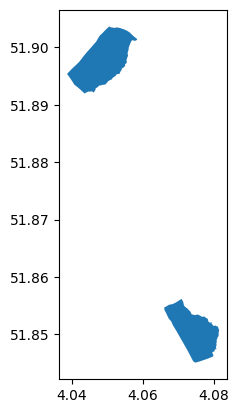

In [41]:
gdf[gdf['naam_n2k'] == "Voornes Duin"][1:2].plot()

In [ ]:
output_name = "Duinen_Goeree_Kwade_Hoek.geojson"

In [9]:
gdf[gdf['naam_n2k'] == "Duinen Goeree & Kwade Hoek"].to_file("Duinen_Goeree_Kwade_Hoek.geojson", driver="GeoJSON")

In [29]:
if len(gpd.read_file("Duinen_Goeree_Kwade_Hoek.geojson")) > 1:
    gpd.GeoDataFrame(geometry=[gpd.read_file("Duinen_Goeree_Kwade_Hoek.geojson").unary_union]).to_file("Duinen_Goeree_Kwade_Hoek.geojson", driver="GeoJSON")

# Test multiploygon cropping

In [32]:
gpd.read_file("Duinen_Goeree_Kwade_Hoek.geojson")

,geometry
0,"MULTIPOLYGON (((3.87698 51.81749, 3.87697 51.8..."


In [25]:
multi_polygon_gdf = gpd.read_file("Duinen_Goeree_Kwade_Hoek.geojson")

<Axes: >

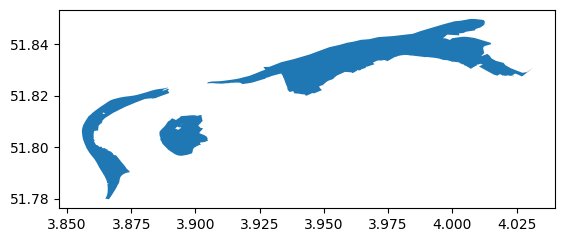

In [27]:
gpd.GeoDataFrame(geometry=[gpd.read_file("Duinen_Goeree_Kwade_Hoek.geojson").unary_union]).plot()

In [20]:
polygon_crop, polygon_download, buffered_polygon = __getFeatures("Duinen_Goeree_Kwade_Hoek.geojson")

Multipolygon detected!
Buffering to grow the different multipolygons together in one polygon for retrieving links


In [22]:
len(polygon_crop)

3

In [14]:
print("Cropping multipolygons")
geometry = []
for x in range(len(polygon_crop)):
            geometry.append(Polygon(polygon_crop[x][0]))

# Change the crs to rijks driehoek, because all the satelliet images are in rijks driehoek
agdf = gpd.GeoDataFrame(geometry=geometry, crs="EPSG:4326").to_crs(epsg=28992)

area_to_crop = mapping(agdf.unary_union) if buffered_polygon else agdf["geometry"]

Cropping multipolygons


<Axes: >

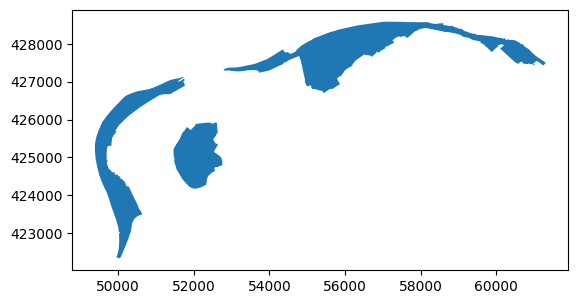

In [17]:
agdf.plot()

In [15]:
area_to_crop 

{'type': 'MultiPolygon',
 'coordinates': [(((50876.327501498134, 426513.2942334182),
    (50872.976746376866, 426511.3606695111),
    (50872.91242576993, 426511.5845778495),
    (50871.44618085296, 426510.7247395778),
    (50854.18666590152, 426499.9546002044),
    (50850.065985511246, 426497.480612817),
    (50797.57902836011, 426464.2950136698),
    (50757.59391955029, 426438.6400471474),
    (50717.52788897809, 426412.4306404579),
    (50691.306509765855, 426395.2815540641),
    (50651.88573651301, 426370.2833804777),
    (50649.998808211414, 426369.09850097995),
    (50649.8586069868, 426368.9901324956),
    (50616.238459662985, 426347.65524661005),
    (50580.241507762854, 426324.812067355),
    (50579.2716630042, 426324.609692382),
    (50549.13229790688, 426301.53345588513),
    (50544.71698684385, 426298.1755577284),
    (50506.514245504426, 426268.81294307666),
    (50470.63029887322, 426241.51671017264),
    (50440.97255190846, 426218.431058362),
    (50428.67349163664, 42621